# Simulated Data Generation in Dymola for Training of the Deep Learning Model Used in Power System (without automation)

Insert the PATH.

In [1]:
import os
import sys
sys.path.insert(0, os.path.join('E:\\', 'Spring2021', 'MnS4CPS', 'Dymola', 'Modelica',
                                'Library', 'python_interface', 'dymola.egg'))

Import libraries


In [2]:
from dymola.dymola_interface import DymolaInterface
from dymola.dymola_exception import DymolaException
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta
import os
import csv
import string
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import MaxPooling1D, Conv1D, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers import GlobalAveragePooling2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Input, Dropout, Conv2D, BatchNormalization, MaxPool2D, Activation
from tensorflow.keras.models import load_model

Set the parameters of the Dymola Model, including the amplitude, the start time, and the end time of the oscillation event.

In [3]:
# Set the Parameter
osci_amp = 4     # Oscillation Amplitude
osci_start = 120 # Oscillation Start Time
osci_end = 200   # Oscillation End Time

Simulate the model and generate the data.

In [4]:
dymola = DymolaInterface() # Instantiate the Dymola interface and start Dymola
dymola.openModel("E:/Spring2021/MnS4CPS/Final Project/2018_AmericanModelicaConf_PowerGrid_plus_PowerSystems/Modelica_Models/OpenCPS_D53B/MLTraining/Configurations/SMIB_normal_noise_signalB_test.mo", mustRead = True, changeDirectory = True)
dymola.cd("E:/Spring2021/MnS4CPS/Final Project/") # change the working directory
dymola.simulateExtendedModel("OpenCPS_D53B.MLTraining.Configurations.SMIB_normal_noise_signalB_test",
                    startTime = 0,
                    stopTime = 300,
                    outputInterval = 0.001,
                    method = "Radau",
                    tolerance = 0.0001,
                    resultFile = 'MLtraining',
                    initialNames = ["signal.sine.amplitude", "signal.greaterThreshold.threshold", "signal.greaterThreshold1.threshold"],
                    initialValues = [osci_amp, osci_start, osci_end],
                    finalNames = ["signal.sine.amplitude", "signal.greaterThreshold.threshold", "signal.greaterThreshold1.threshold"])
num_of_rows = dymola.readTrajectorySize("MLtraining.mat")
data = dymola.readTrajectory("MLtraining.mat", ["Time", "power_System.pMU.freq", "power_System.BUS3.V"], num_of_rows)
time = data[0]
PMU_Freq = data[1]
BUS3_V = data[2]

Draw frequency measurement at PMU component.

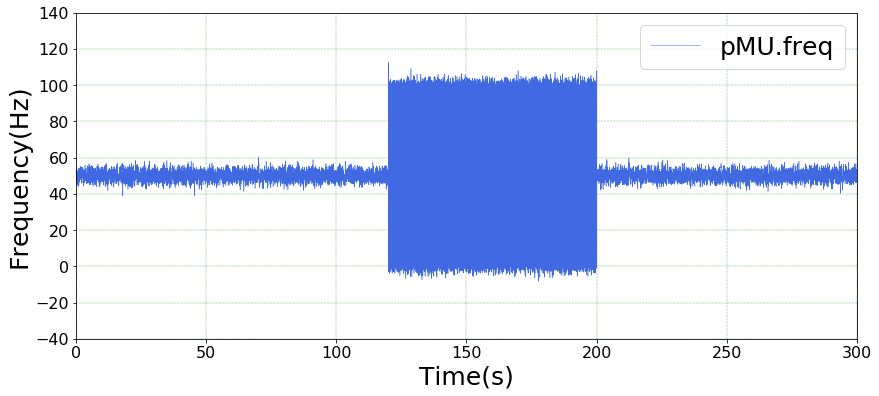

In [5]:
# Plot pMU.freq
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(time, PMU_Freq, color='royalblue', alpha = 1, linewidth=0.5, label="pMU.freq")
ax1.set_ylim([-40,140])
ax1.set_xlim([0,300])
ax1.set_ylabel('Frequency(Hz)', color='black', fontsize=25)
ax1.set_xlabel('Time(s)', color='black', fontsize=25)
ax1.grid(color='g', ls = '-.', lw = 0.3)
plt.legend(loc="upper right", fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Draw voltage at BUS3.

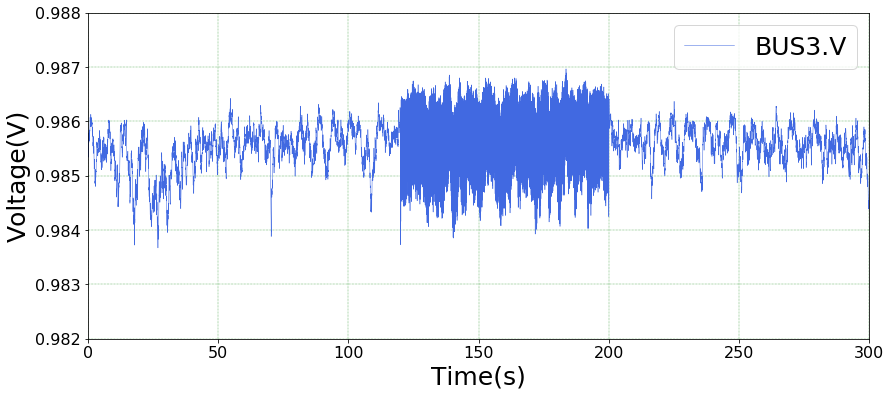

In [6]:
# Plot BUS3.V
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(time, BUS3_V, color='royalblue', alpha = 1, linewidth=0.5, label="BUS3.V")
ax1.set_ylim([0.982,0.988])
ax1.set_xlim([0,300])
ax1.set_ylabel('Voltage(V)', color='black', fontsize=25)
ax1.set_xlabel('Time(s)', color='black', fontsize=25)
ax1.grid(color='g', ls = '-.', lw = 0.3)
plt.legend(loc="upper right", fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Reshape the data for ML training.

In [7]:
# Extract noise data into a dataset for training
# Noisy Signal (0s->120s and 200s->300s)
# Extract oscillation data into a dataset for Training
# Oscillation Signal (120s->200s)
index = 0
timeindex = 0.0
increment = 4.5
num = 31
dataset = []
labels = []
list1 = [[]]
list2 = []

while True:
    if time[index] >=290:
        break
    
    list1[0].append(BUS3_V[index])
    
    if len(list1[0]) == 31:
        list1 = np.array(list1)
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(list1.reshape(-1,1)).reshape((1,31))
        x_train_LSTM = np.reshape(x_scaled, (x_scaled.shape[0], x_scaled.shape[1], 1))
        for i in range(31):
            list2.append(x_train_LSTM[0][i][0])
        dataset.append(list2)
        list2 = []
        list1 = [[]]
        if time[index] < osci_start or time[index] > osci_end:
            labels.append(1)
        else:
            labels.append(0)
    
    timeindex += increment
    index = int(timeindex)

dataset = np.array(dataset)
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2)

In [8]:
y_test

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,

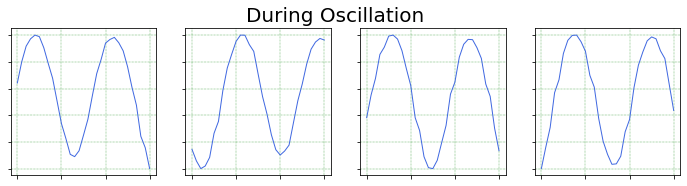

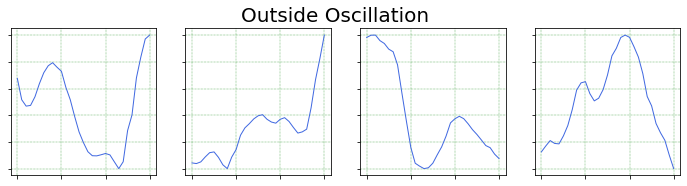

In [9]:
# Conv1D Training
#print(X_train[1])
#print(y_train[1])
#print(y_train)

fig, ax1 = plt.subplots(1, 4, figsize=(12,3))
fig.autofmt_xdate()
fig.suptitle('During Oscillation', color='black', fontsize=20)
empty_string_labels = ['']*len(labels)

ax1[0].plot(np.arange(31), X_test[3], color='royalblue', alpha = 1, linewidth=1)
ax1[0].grid(color='g', ls = '-.', lw = 0.3)
ax1[0].set_xticklabels(empty_string_labels)
ax1[0].set_yticklabels(empty_string_labels)
ax1[1].plot(np.arange(31), X_test[4], color='royalblue', alpha = 1, linewidth=1)
ax1[1].grid(color='g', ls = '-.', lw = 0.3)
ax1[1].set_xticklabels(empty_string_labels)
ax1[1].set_yticklabels(empty_string_labels)
ax1[2].plot(np.arange(31), X_test[8], color='royalblue', alpha = 1, linewidth=1)
ax1[2].grid(color='g', ls = '-.', lw = 0.3)
ax1[2].set_xticklabels(empty_string_labels)
ax1[2].set_yticklabels(empty_string_labels)
ax1[3].plot(np.arange(31), X_test[12], color='royalblue', alpha = 1, linewidth=1)
ax1[3].grid(color='g', ls = '-.', lw = 0.3)
ax1[3].set_xticklabels(empty_string_labels)
ax1[3].set_yticklabels(empty_string_labels)
plt.show()

fig, ax2 = plt.subplots(1, 4, figsize=(12,3))
fig.suptitle('Outside Oscillation', color='black', fontsize=20)
fig.autofmt_xdate()

ax2[0].plot(np.arange(31), X_test[0], color='royalblue', alpha = 1, linewidth=1)
ax2[0].grid(color='g', ls = '-.', lw = 0.3)
ax2[0].set_xticklabels(empty_string_labels)
ax2[0].set_yticklabels(empty_string_labels)
ax2[1].plot(np.arange(31), X_test[1], color='royalblue', alpha = 1, linewidth=1)
ax2[1].grid(color='g', ls = '-.', lw = 0.3)
ax2[1].set_xticklabels(empty_string_labels)
ax2[1].set_yticklabels(empty_string_labels)
ax2[2].plot(np.arange(31), X_test[2], color='royalblue', alpha = 1, linewidth=1)
ax2[2].grid(color='g', ls = '-.', lw = 0.3)
ax2[2].set_xticklabels(empty_string_labels)
ax2[2].set_yticklabels(empty_string_labels)
ax2[3].plot(np.arange(31), X_test[5], color='royalblue', alpha = 1, linewidth=1)
ax2[3].grid(color='g', ls = '-.', lw = 0.3)
ax2[3].set_xticklabels(empty_string_labels)
ax2[3].set_yticklabels(empty_string_labels)
plt.show()

Build the 1D convolutional model and train it using the data generated by Dymola.

In [10]:
TIME_PERIODS = 31
num_time_periods = 31
num_sensors = 1
num_classes = 2
input_shape = (num_time_periods*num_sensors)
kernel_size=3

model_conv1D = Sequential()
model_conv1D.add(Conv1D(64, kernel_size, activation='relu', input_shape=(31,1)))
model_conv1D.add(Conv1D(64, kernel_size, activation='relu'))
model_conv1D.add(MaxPooling1D(2))
model_conv1D.add(Dropout(0.5))
model_conv1D.add(Flatten())
model_conv1D.add(Dense(100, activation='relu'))
model_conv1D.add(Dense(num_classes, activation='softmax'))

model_conv1D.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_conv1D.summary())

X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

history = model_conv1D.fit(X_train_reshaped, y_train, epochs=50,
          batch_size=100, verbose=1,
          validation_data=(X_test_reshaped, y_test))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 832)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               83300     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

1976/1976 [==============================] - 0s 169us/sample - loss: 0.0120 - accuracy: 0.9970 - val_loss: 0.0165 - val_accuracy: 0.9939
Epoch 48/50
1976/1976 [==============================] - 0s 154us/sample - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.0191 - val_accuracy: 0.9919
Epoch 49/50
1976/1976 [==============================] - 0s 152us/sample - loss: 0.0124 - accuracy: 0.9949 - val_loss: 0.0180 - val_accuracy: 0.9939
Epoch 50/50
1976/1976 [==============================] - 0s 150us/sample - loss: 0.0142 - accuracy: 0.9939 - val_loss: 0.0257 - val_accuracy: 0.9899


Save the trained conv1D model to a local repository.

In [11]:
# Save the Trained Model
model_conv1D.save('E:/Spring2021/MnS4CPS/Final Project/conv1D_dymola.h5')

Print the training history.

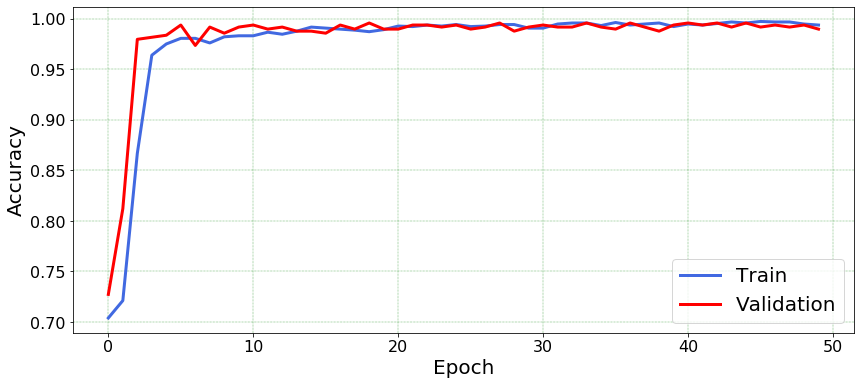

In [12]:
def printHistory(history):
       loss_curve = history.history["loss"]
       acc_curve = history.history["accuracy"]

       loss_val_curve = history.history["val_loss"]
       acc_val_curve = history.history["val_accuracy"]

       fig, axs = plt.subplots(figsize=(14,6))
       axs.plot(acc_curve, color='royalblue', alpha = 1, linewidth=3.0, label="Train")
       axs.plot(acc_val_curve, color='red', alpha = 1, linewidth=3.0, label="Validation")
       axs.set_ylabel('Accuracy', fontsize=20)
       axs.set_xlabel('Epoch', fontsize=20)
       axs.grid(color='g', ls = '-.', lw = 0.3)
       plt.xticks(fontsize = 16)
       plt.yticks(fontsize = 16)
       plt.legend(loc='lower right', fontsize=20)
       plt.show()
printHistory(history)

In [13]:
# Load Model
from tensorflow.keras.models import load_model
model_conv1D = load_model("E:/Spring2021/MnS4CPS/Final Project/conv1D_dymola.h5")

In [14]:
# Prepare Real Data
import pandas as pd

def prepareImportedDF(df):
       df['Timestamp'] = pd.to_datetime(df['Timestamp'])
       df['tmp'] = (df['Timestamp'].apply(lambda x: float(x.timestamp())) )
       df.insert(0, 'Timestamps', df['tmp'])
       df.drop(columns=['tmp'], inplace=True)
       df.sort_values(by=['Timestamps'], inplace=True)

OpenFile3 = r"E:\Spring 2020\Research\GridX\Training Datas\CSV files\New Folder\2018-05-15 02.50.59 Fort Smith Area_fixed.csv"
df3 = pd.read_csv(OpenFile3, header = 0, error_bad_lines=False)
prepareImportedDF(df3)

(22710, 27)
Processing Terminal MaudTap-Fixico 
 - Batch done for MaudTap-Fixico- 


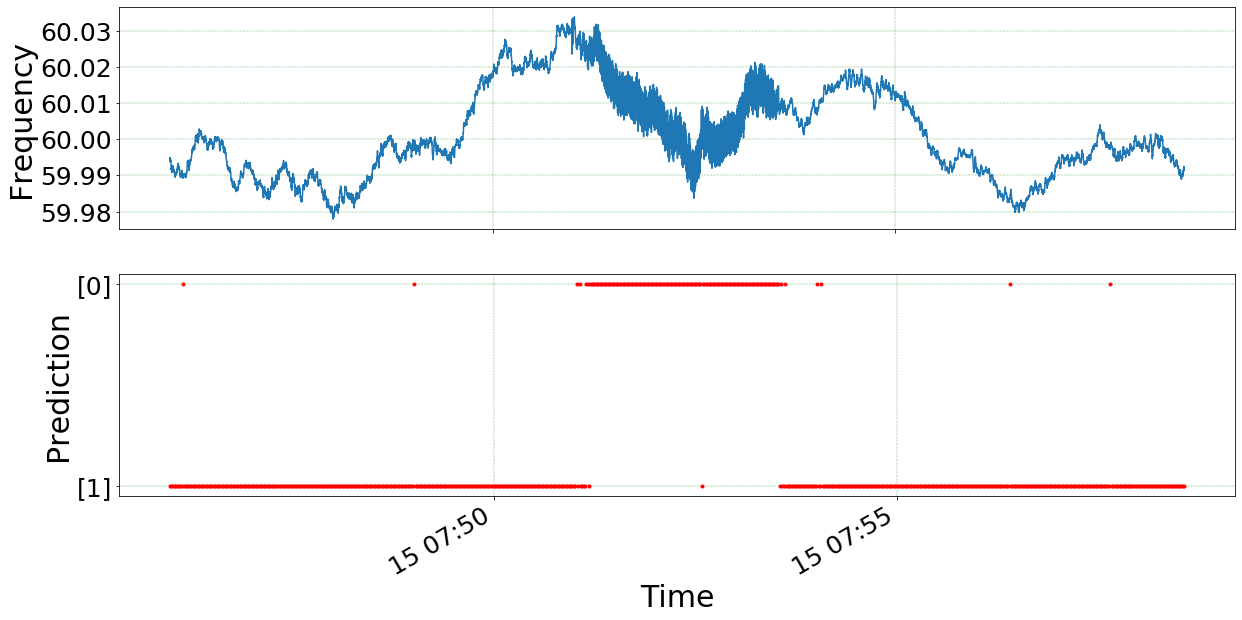

In [20]:
# Predict on Real Data
from datetime import timedelta
import os
import csv
import string

def slugify(value):
    valid_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
    return ''.join(c for c in value if c in valid_chars)

# This function is used to append one row of data to a csv file.
def writeLineToCSV(CSVfile, line):
       # 'a': Open a file for append. If the file already exists, the file pointer will be placed at the end of the file. That is, the new content will be written to the existing content. If the file does not exist, create a new file to write to.
       # If csvfile is a file object, it should be opened with newline=''. 
       file = open(CSVfile, 'a', newline='')
       with file:
              writer = csv.writer(file)
              writer.writerow(line.split(","))

def getNSec(datas, startDate, nbSEC):
       if startDate is None:
              startDate = datas["Timestamp"].values[0]
       r = datas[(datas["Timestamp"] >= pd.to_datetime(startDate))]
       endDate = pd.to_datetime(startDate) + timedelta(seconds = nbSEC)
       r = r[(r["Timestamp"] <= pd.to_datetime(endDate))]
       return r

def writeHeaderPredictionInCSV(filePath):
       header = 'Timestamp'
       header += ' Prediction'
       header = header.split()
       file = open(filePath, 'w', newline='')
       with file:
              writer = csv.writer(file)

              writer.writerow(header)

def ExportPrediction_Dense(model, datas, PlotNsecOfData = 1, SlidingWindowSec = 1, columnName = "Terminal", exportName =None, isDense = False):
    for g,k in datas.groupby('TermID'):
        dftmp = k
        StationName=slugify(str(dftmp[columnName].values[0]))
        if exportName is not None:
            StationName = exportName
        print(f"Processing Terminal {StationName} ")

        if not os.path.exists("E:/Spring 2020/Research/GridX/exports/Prediction"):
                os.makedirs("E:/Spring 2020/Research/GridX/exports/Prediction" )

        fileNameIN = "E:/Spring 2020/Research/GridX/exports/Prediction/" + StationName + ".csv"

        writeHeaderPredictionInCSV(fileNameIN)
        Datemax = pd.to_datetime(dftmp["Timestamp"].max())
        startAT = pd.to_datetime(dftmp["Timestamp"].values[0])

        while True:
                dataIN = getNSec(dftmp, startAT, PlotNsecOfData)

                if dataIN.shape[0] > 1:
                    data_tmp = dataIN["FREQ"].values

                    min_max_scaler = preprocessing.MinMaxScaler()
                    x_scaled = min_max_scaler.fit_transform(data_tmp.reshape(-1, 1)).reshape((1, 31))
                    #print(x_scaled)
                    #break
                    to_append = f'{startAT}' 
                    if isDense == True:
                        predictions = model.predict(x_scaled)   # THIS WORK FOR DENSE
                    else:
                        #X_train_LSTM = np.reshape(x_scaled, (x_scaled.shape[0], 1, x_scaled.shape[1]))   #THIS WORK FOR LSTM
                        X_train_LSTM = np.reshape(x_scaled, (x_scaled.shape[0], x_scaled.shape[1],1 ))  #THIS WORK FOR CONV1D
                        predictions = model.predict(X_train_LSTM)
                    #print(predictions)
                    resPrediction = np.argmax(predictions, axis=1)
                    #resPrediction =predictions[0]

                    to_append += f',{resPrediction}'
                    writeLineToCSV(fileNameIN, to_append)

                startAT += timedelta( seconds = SlidingWindowSec)
                
                if startAT + timedelta( seconds = PlotNsecOfData) > Datemax:
                    print(f" - Batch done for {StationName}- ")
                    break
                #break
        #break
        
def showModelPrediction_Dense(model, datas, terminalName, columnName = "Terminal", ignoreTerminalFilter = False, PlotNsecOfData = 1, SlidingWindowSec = 1, isDense = False):
       datas_tmp = datas
       if ignoreTerminalFilter is False:
        datas_tmp = datas[(datas[columnName]==terminalName)]
       
        print(datas_tmp.shape)
       ExportPrediction_Dense(model,datas_tmp, PlotNsecOfData = PlotNsecOfData, SlidingWindowSec = SlidingWindowSec, columnName = columnName, isDense = isDense)

       dataPredictions = pd.read_csv(f"E:/Spring 2020/Research/GridX/exports/Prediction/{terminalName}.csv", header = 0)
       dataPredictions['Timestamp'] = pd.to_datetime(dataPredictions['Timestamp'])

       fig, axs = plt.subplots(2, 1, figsize=(20,10), sharex=False)
       fig.autofmt_xdate()
       axs[0].plot(datas_tmp["Timestamp"],datas_tmp["FREQ"])
       axs[0].set_ylabel('Frequency', fontsize=30)
       axs[0].grid(color='g', ls = '-.', lw = 0.3)

       axs[1].plot(dataPredictions["Timestamp"],dataPredictions["Prediction"], "r.")
       axs[1].set_ylabel('Prediction', fontsize=30)
       axs[1].set_xlabel('Time', fontsize=30)
       axs[1].grid(color='g', ls = '-.', lw = 0.3)
       plt.xticks(fontsize = 25)
       plt.yticks(fontsize = 25)
       plt.sca(axs[0])
       plt.yticks(fontsize = 25)
       plt.show()

showModelPrediction_Dense(model_conv1D, df3, "MaudTap-Fixico")